In [1]:
import torch
from mutect3 import data, validation, tensors, networks

%matplotlib inline

In [2]:
torch.sigmoid(torch.tensor(-6.))

tensor(0.0025)

In [3]:
GENERATE_PICKLES = False
if GENERATE_PICKLES:
    table_dir = '/Users/davidben/broad/mutect3/tables/'
    pickle_dir = '/Users/davidben/broad/mutect3/pickles/'
    dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
    tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
    normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

    for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
        print("Generating tensors for " + dream)

        tumor_table, normal_table = (table_dir + dream + suffix for suffix in ('-tumor.table', '-normal.table'))
        pair_train_pickle, small_pair_train_pickle, tumor_train_pickle, normal_train_pickle, test_pickle, small_test_pickle = \
            (pickle_dir + dream + suffix for suffix in ('-pair-train.pickle', '-small-pair-train.pickle', '-tumor-train.pickle' \
                                                       '-normal-train.pickle', '-test.pickle', '-small-test.pickle'))

        # we form a few kinds of training data: tumor data using the normal 
        # (the normal doesn't change the format but helps make better truth guesses)
        print("Generating and pickling tumor tensors for training using tumor and normal")
        pair_train_data = tensors.make_tensors(tumor_table, True, tumor_sample, normal_sample)
        tensors.make_pickle(pair_train_pickle, pair_train_data)

        print("Generating and pickling small (by 10x) tumor tensors for training using tumor and normal")
        tensors.make_pickle(small_pair_train_pickle, pair_train_data[:int(len(pair_train_data)/10)])

        print("Generating and pickling tumor tensors for training using only tumor")
        tumor_train_data = tensors.make_tensors(tumor_table, True, tumor_sample)
        tensors.make_pickle(tumor_train_pickle, tumor_train_data)

        print("Generating and pickling normal tensors for training using only normal")
        normal_train_data = tensors.make_tensors(normal_table, True, normal_sample)
        tensors.make_pickle(normal_train_pickle, normal_train_data)

        print("Generating and pickling tumor tensors for testing using STATUS labels")
        test_data = tensors.make_tensors(tumor_table, False, tumor_sample, normal_sample)
        tensors.make_pickle(test_pickle, test_data)

        print("Generating and pickling small (by 10x) tumor tensors for for testing using STATUS labels")
        tensors.make_pickle(small_test_pickle, test_data[:int(len(test_data)/10)])

In [4]:
BATCH_SIZE = 64
def run_evaluation(training_pickles, test_pickle, num_epochs):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = data.make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect_info().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    # Learn model
    train_loader, valid_loader, test_loader = data.make_data_loaders(train, valid, test)
    model = networks.ReadSetClassifier([20, 20], [10, 10], [10], {'normal_artifact'}).float()
    training_metrics = model.train_model(train_loader, valid_loader, test_loader, num_epochs, BATCH_SIZE)
    training_metrics.plot_all_metrics()
    model.get_prior_model().plot_spectra()
    
    #plot purported ROC curve
    validation.get_optimal_f_score(model, test_loader, make_plot=True)

    logit_threshold = model.calculate_logit_threshold(test_loader)
    print("Optimal logit threshold: " + str(logit_threshold))
    
    validation.show_validation_plots(model, test_loader, logit_threshold)

    return model
        

In [5]:
DIR = '/Users/davidben/broad/mutect3/pickles/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_1_SMALL_PAIR = DIR + 'dream1-small-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_1_SMALL_TEST = DIR + 'dream1-small-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 17221, validation: 1914, test: 2547
Training data includes 4 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Confidence params before calibration: 
[0.0, 1.060672640800476, 1.8624035120010376, 2.2834460735321045, 2.476881980895996, 2.5572071075439453, 2.67427921295166, 2.8785455226898193, 2.8506088256835938, 2.9878618717193604, 3.194406270980835]
Confidence params after calibration: 
[0.0, 2.435171365737915, 2.173795223236084, 3.0605151653289795, 3.6034746170043945, 3.084063768386841, 3.7748587131500244, 3.765040159225464, 2.347073793411255, 3.3822598457336426, 1.8384960889816284]
Prior log odds: 4.0
Prior log odds: 0.48476219177246094
Prior log odds: -0.7828331589698792
Prior log odds: -0.9864685535430908
Prior log odds: -1.0134429931640625
Prior log odds: -1.0181946754455566
Prior log odds: -1.0199179649353027
Prior log odds: -1.0209835767745972
Prior log odds: -1.021742582321167
Prior log odd

ReadSetClassifier(
  (phi): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=20, bias=True)
    )
    (bn): ModuleList()
  )
  (omega): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
    )
    (bn): ModuleList()
  )
  (rho): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=1, bias=True)
    )
    (bn): ModuleList()
  )
  (prior_model): PriorModel(
    (variant_spectrum): AFSpectrum()
    (artifact_spectrum): AFSpectrum()
  )
)

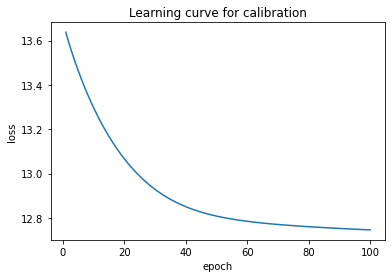

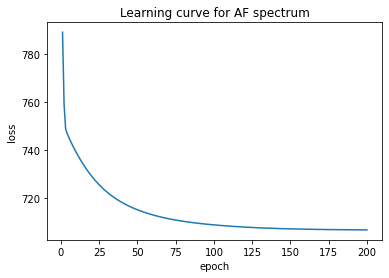

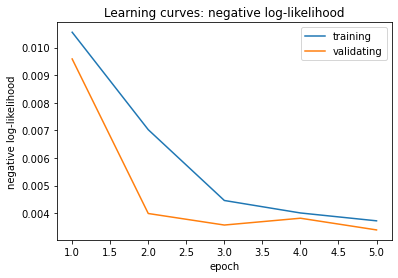

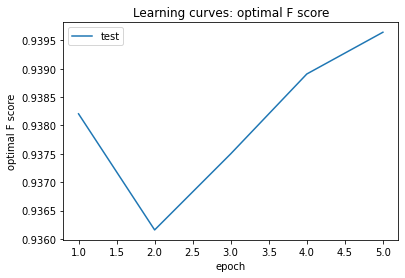

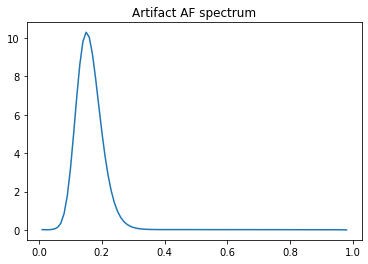

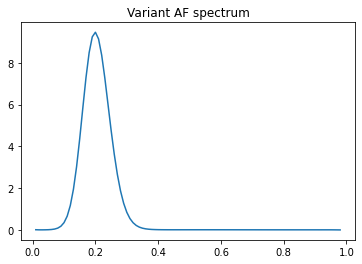

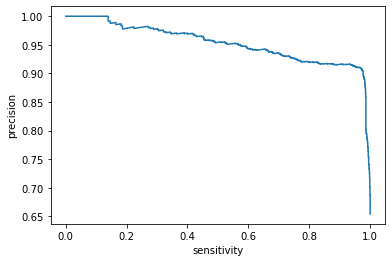

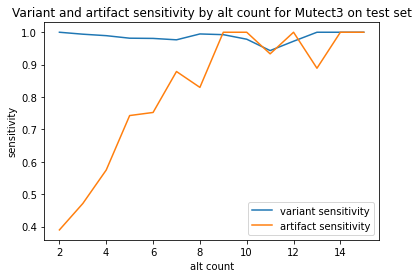

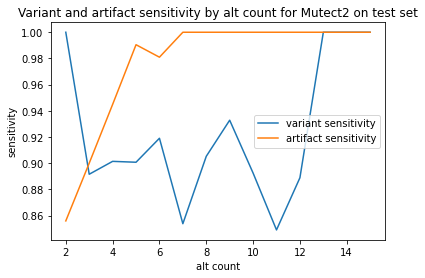

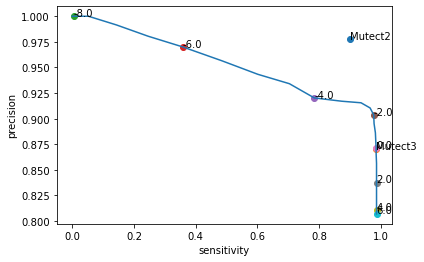

In [6]:
run_evaluation([DREAM_1_SMALL_PAIR], DREAM_1_SMALL_TEST, 5)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 16 PASS variants labelled as artifacts.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Confidence params before calibration: 
[0.0, 2.887572765350342, 3.308511972427368, 3.4564826488494873, 3.4957642555236816, 3.036937952041626, 2.970336675643921, 3.837383985519409, 3.178006649017334, 2.935417413711548, 2.973876953125]
Confidence params after calibration: 
[0.0, 2.7542827129364014, 3.5174450874328613, 3.3901093006134033, 4.429189682006836, 3.299158811569214, 4.318728446960449,

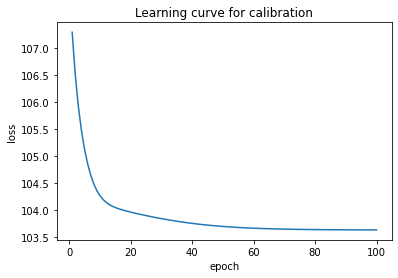

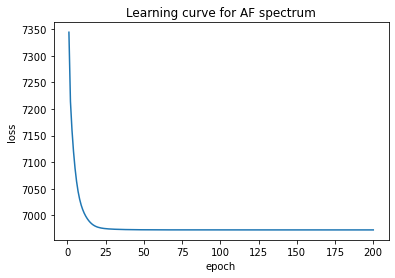

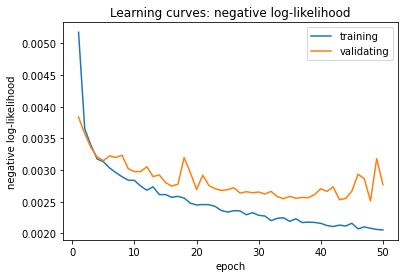

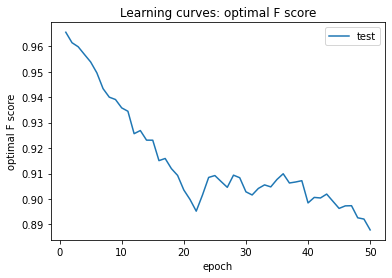

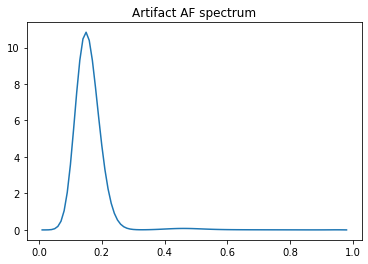

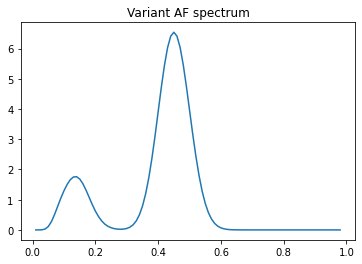

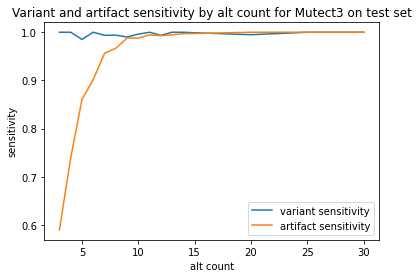

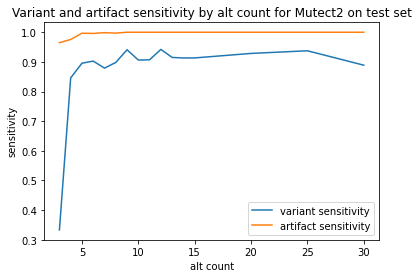

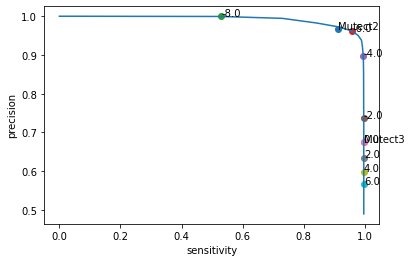

In [8]:
trained_model = run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 50)

In [7]:
trained_model.confidence, trained_model.max_logit

(Parameter containing:
 tensor([ 0.0000, 16.6358,  1.9316,  2.1534,  2.5855,  2.4859,  3.2710,  2.0998,
          2.1983,  2.2976,  3.3216]),
 Parameter containing:
 tensor(13.6465))

In [8]:
trained_model.confidence, trained_model.max_logit

Parameter containing:
tensor([0.0000, 1.3503, 3.6231, 3.3818, 2.6853, 2.7240, 3.6739, 3.2177, 2.2050,
        3.8816, 2.3083])

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_4_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_2_PAIR], DREAM_1_TEST, 50)